## Prepare Data

In [2]:
from utils import SignalDataset
from torch.utils.data import DataLoader
data_path = "/home/cmu/anthony/FaultFormer/FaultFormer/data/CWRU/kfold/training_data_0"
label_path = "/home/cmu/anthony/FaultFormer/FaultFormer/data/CWRU/kfold/training_labels_0"

In [47]:
def prepare_data(data_path, label_path, batch_size, mode='train'):
    dataset = SignalDataset(data_path, label_path)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [4]:
train_loader = prepare_data(data_path, label_path, 32)

In [5]:
x, y = next(iter(train_loader))

In [37]:
import torch
pddata = torch.load("/home/cmu/anthony/FaultFormer/FaultFormer/data/Paderborn/kfold/test_data_1")

In [38]:
pddata.shape

torch.Size([11600, 2500])

In [3]:
import torch
import numpy as np


data_total = torch.tensor(np.load("/home/cmu/anthony/FaultFormer/FaultFormer/data/CWRU/signal_data.npy"))
label_total = torch.tensor(np.load("/home/cmu/anthony/FaultFormer/FaultFormer/data/CWRU/signal_data_labels.npy"))


In [38]:
def split_based_on_labels(x, y, idx = [3, 6, 9]):
    num_idx = len(idx)
    data_idx, data_non_idx = torch.Tensor(), torch.Tensor()
    labels_idx, labels_non_idx = torch.Tensor(), torch.Tensor()
    for d,l in zip(x,y):
        if (l.expand(1, num_idx) == torch.tensor(idx)).sum() > 0:
            data_idx = torch.cat((data_idx, d.unsqueeze(0)))
            labels_idx = torch.cat((labels_idx, l.unsqueeze(0)))
        else:
            data_non_idx = torch.cat((data_non_idx, d.unsqueeze(0)))
            labels_non_idx = torch.cat((labels_non_idx, l.unsqueeze(0)))

    return data_idx, data_non_idx, labels_idx, labels_non_idx
    

In [86]:
from models import BERT
from wrappers import MaskedWrapper
import torch.nn as nn
train_string = "/home/cmu/anthony/FaultFormer/FaultFormer/NewAndImprovedISwearItWorks/data_uwu/pretraining_data_0124578.pt"
train_loader = prepare_data(train_string, None, 16)

bert = BERT(d_in=8,
            d_model = 128,
            nhead = 16,
            num_layers= 2,
            dropout = 0,
            )
reconstruction_net = nn.Linear(in_features=128, out_features=8)

model = MaskedWrapper(net=bert,
                        reconstruction_net=reconstruction_net,
                        mask_prob = 1,
                        replace_prob = .9,
                            random_token_prob = .1)

In [50]:
x = next(iter(train_loader))

In [51]:
x.shape

torch.Size([16, 1600])

In [4]:
torch.save(data_total, "data_uwu/pretraining_data_full.pt")
torch.save(label_total, "data_uwu/pretraining_labels_full.pt")

In [53]:
from Tokenizer import SignalTokenizer
tokenizer = SignalTokenizer(num_tokens=200)

In [59]:
tokens = tokenizer.forward(x).type(torch.FloatTensor)

In [56]:
tokens.shape

torch.Size([16, 200, 8])

In [60]:
tokens

tensor([[[ 9.1813e-02,  7.0947e-03, -7.3868e-02,  ..., -2.0366e-01,
          -2.1201e-01, -1.6902e-01],
         [-3.2135e-02,  1.2854e-01,  2.7210e-01,  ...,  3.3428e-01,
           2.7544e-01,  1.8446e-01],
         [ 4.0064e-02, -1.6359e-01, -3.4639e-01,  ..., -3.3053e-01,
          -1.8738e-01, -2.1284e-02],
         ...,
         [-6.6773e-02,  9.1521e-01,  1.6698e+00,  ...,  1.8901e+00,
           1.3668e+00,  6.8359e-01],
         [ 2.0032e-02, -4.6282e-01, -7.1740e-01,  ..., -3.3971e-01,
          -9.1396e-02,  9.0979e-02],
         [ 1.8154e-01,  9.7656e-02, -1.5942e-01,  ..., -8.8057e-01,
          -7.7123e-01, -4.7409e-01]],

        [[-3.2335e-02,  2.1696e-02,  7.1972e-02,  ...,  2.0820e-01,
           1.9693e-01,  1.5187e-01],
         [ 9.2208e-02,  5.2154e-02,  2.7954e-02,  ..., -1.1682e-02,
           9.8049e-03,  6.4254e-02],
         [ 1.3581e-01,  1.9318e-01,  2.1467e-01,  ...,  1.6209e-01,
           1.1516e-01,  4.3809e-02],
         ...,
         [ 2.3156e-02,  2

In [87]:
x_pred, orig_seq, x_masked = model(tokens, mode = "test")

In [88]:
idx = 0

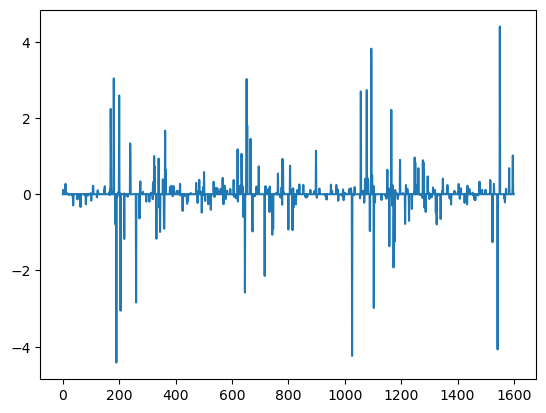

In [89]:
import matplotlib.pyplot as plt

plt.plot(torch.arange(1600), torch.flatten(x_masked[idx], 0, 1).detach())

In [1]:
import torch

data_369 = torch.load("data_uwu/data_369/training_data_369.pt")
labels_369 = torch.load("data_uwu/data_369/training_labels_369.pt")

In [5]:
l = labels_369//4

In [8]:
torch.save(l, "data_uwu/data_369/training_labels_369_norm.pt")

In [36]:
from torch.utils.data import DataLoader
import random
import wandb
from datetime import datetime
import argparse
import torch
import torch.nn as nn
import numpy as np

from Tokenizer import SignalTokenizer
from wrappers import MaskedWrapper, FinetuneWrapper
from models import BERT
from utils import SignalDataset

parser = argparse.ArgumentParser(description='Pretrain FaultFormer')

# BERT parameters
parser.add_argument('--batch_size', type=int, default=16,
        help='Number of samples in each minibatch')
parser.add_argument('--num_epochs', type=int, default=100,
        help='Number of training epochs')
parser.add_argument('--d_in', type=int, default=8,
        help='Input dimension of BERT')
parser.add_argument('--d_out', type=int, default=3,
                    help='Output dimension of BERT')
parser.add_argument('--d_model', type=int, default=128,
        help='Model dimension of BERT')
parser.add_argument('--nhead', type=int, default=4,
        help='Number of heads in BERT')
parser.add_argument('--num_layers', type=int, default=2,
        help='Number of layers in BERT')
parser.add_argument('--dropout', type=float, default=0,
            help='Dropout probability in BERT')

# Reconstruction parameters
parser.add_argument('--mask_prob', type=float, default=0.15,
        help='Probability to mask out a token')
parser.add_argument('--replace_prob', type=float, default=0.9,
        help='Probability to replace a masked token with 0')
parser.add_argument('--random_token_prob', type=float, default=0.1,
        help='Probability to replace a masked token with a random token')

# Optimizer parameters
parser.add_argument('--min_lr', type=float, default=1e-4,
        help='Minimum learning rate')
parser.add_argument('--max_lr', type=float, default=1e-3,
        help='Maximum learning rate')
parser.add_argument('--beta1', type=float, default=0.9,
        help='Adam beta1')
parser.add_argument('--beta2', type=float, default=0.98,
        help='Adam beta2')

# Scheduler parameters
parser.add_argument('--pct_start', type=float, default=0.1,
        help='Percentage of training to increase learning rate')

# Tokenizer parameters
parser.add_argument('--num_tokens', type=int, default=200,
        help='Number of tokens to generate from a PDE time/spatial sequence')
parser.add_argument('--mode', type=str, default='constant',
            help='Mode for tokenization: [constant, bicubic, fourier]')
args = parser.parse_args("")

/home/cmu/anaconda3/envs/torch2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [37]:
device = 'cuda'
rank = device
generator = torch.Generator().manual_seed(42)
data_path = "/home/cmu/anthony/FaultFormer/FaultFormer/NewAndImprovedISwearItWorks/data_uwu/data_369/training_data_369.pt"
labels_path = "/home/cmu/anthony/FaultFormer/FaultFormer/NewAndImprovedISwearItWorks/data_uwu/data_369/training_labels_369_norm.pt"

dataset = SignalDataset(data_path, labels_path)
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2], generator=generator)
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=False)

bert = BERT(d_in=args.d_in,
            d_model = args.d_model,
            nhead = args.nhead,
            num_layers= args.num_layers,
            dropout = args.dropout,
            )
embedding_net = nn.Linear(in_features=args.d_model, out_features=args.d_out)

tokenizer = SignalTokenizer(num_tokens=args.num_tokens, mode=args.mode)
model = FinetuneWrapper(net = bert,
                        embedding_net=embedding_net,
                        tokenizer=tokenizer).to(rank)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Number of BERT parameters: {params}')
optimizer = torch.optim.AdamW(model.parameters(), lr=args.min_lr, betas=(args.beta1, args.beta2))
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                    max_lr=args.max_lr, 
                                                    steps_per_epoch= len(train_loader), 
                                                    epochs=args.num_epochs, 
                                                    pct_start=args.pct_start, 
                                                    anneal_strategy='cos', 
                                                    final_div_factor=args.max_lr/args.min_lr)
criterion = nn.CrossEntropyLoss().to(rank)

Number of BERT parameters: 660611


In [38]:
x, y = next(iter(train_loader))

In [45]:
test = torch.Tensor([-1, 0, 1])
s(test)

/home/cmu/anaconda3/envs/torch2/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([0.0900, 0.2447, 0.6652])

In [43]:
model(x.to(rank))

tensor([[-0.7805,  0.4619,  0.7694],
        [-0.7785,  0.4631,  0.7642],
        [-0.7855,  0.4324,  0.7857],
        [-0.7557,  0.4572,  0.7939],
        [-0.7915,  0.4330,  0.7960],
        [-0.7807,  0.4410,  0.7943],
        [-0.7725,  0.4665,  0.7651],
        [-0.7856,  0.4426,  0.7850],
        [-0.7836,  0.4466,  0.7866],
        [-0.7758,  0.4677,  0.7565],
        [-0.7761,  0.4670,  0.7667],
        [-0.7757,  0.4198,  0.8109],
        [-0.7835,  0.4400,  0.7903],
        [-0.7850,  0.4517,  0.7822],
        [-0.7807,  0.4414,  0.7893],
        [-0.7860,  0.3893,  0.8382]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

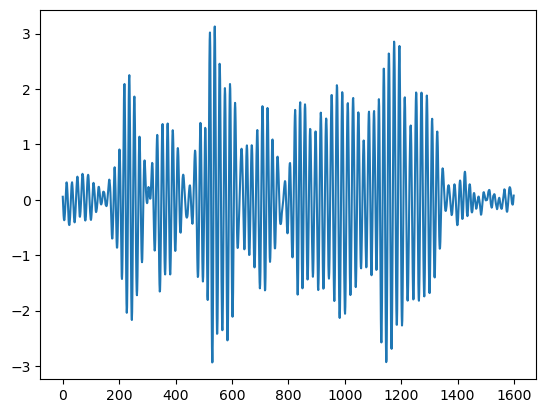

In [16]:
import matplotlib.pyplot as plt
plt.plot(torch.arange(1600), x[4])

In [62]:
y.shape

torch.Size([16])

In [64]:
x[0].std()

tensor(0.7825)

In [3]:
x, y = next(iter(train_loader))

# Tokenize data to shape (batch_size, num_tokens, d_in)
tokens = tokenizer.forward(x).to(device)

# Forward pass
pred = model(tokens)
loss = criterion(pred, y.to(device))

# Backward pass
loss.backward()

In [7]:
# Tokenize data to shape (batch_size, num_tokens, d_in)
tokens = tokenizer.forward(x).to(device)

# Forward pass
pred = model(tokens)
loss = criterion(pred, y.to(device))

pred_labels = torch.argmax(pred, dim=1).cpu()
num_correct = (pred_labels == y).sum()
accs = num_correct / args.batch_size

In [8]:
num_correct

tensor(6)

In [9]:
pred

tensor([[ 0.8033, -0.2473, -0.4833],
        [ 0.8222, -0.2344, -0.4785],
        [ 0.7955, -0.2595, -0.4826],
        [ 0.7744, -0.2471, -0.4914],
        [ 0.8062, -0.2575, -0.4817],
        [ 0.7670, -0.2527, -0.5195],
        [ 0.7699, -0.2479, -0.5091],
        [ 0.7754, -0.2447, -0.5069],
        [ 0.8201, -0.2453, -0.4888],
        [ 0.7897, -0.2656, -0.4791],
        [ 0.8068, -0.2578, -0.4762],
        [ 0.7915, -0.2692, -0.4871],
        [ 0.7651, -0.2545, -0.5074],
        [ 0.7821, -0.2568, -0.4895],
        [ 0.7566, -0.2682, -0.4868],
        [ 0.8132, -0.2423, -0.4901]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [10]:
pred_labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [11]:
y

tensor([0, 0, 2, 2, 0, 1, 1, 1, 0, 2, 0, 2, 1, 2, 2, 0])

In [12]:
accs

tensor(0.3750)

In [66]:
test = torch.Tensor([[.11,.1,.1]])
test1 = torch.Tensor([[1,1.1,1]])
labels = torch.Tensor([1]).type(torch.LongTensor)

print(criterion(test, labels))
print(criterion(test1, labels))

tensor(1.1020)
tensor(1.0331)


## Conv

In [3]:
import torch, torch.nn as nn


In [32]:
test = torch.randn(16, 1, 1600)
CNN = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=8, stride=4, padding='valid')

In [33]:
out = CNN(test)

In [34]:
out.shape

torch.Size([16, 1, 399])

In [37]:
tokenizer_model = nn.Sequential(
    nn.Conv1d(in_channels=1, out_channels=3, kernel_size=4, stride=2, padding="valid"),
    nn.Conv1d(in_channels=3, out_channels=3, kernel_size=4, stride=2, padding="valid"),
)

In [38]:
tokenizer_model(test).shape

torch.Size([16, 3, 398])

In [4]:
from models import BERT    
bert = BERT(d_in=3,
             d_model = 64,
             nhead = 4,
             num_layers= 4,
             dropout = 0,
             )

/home/cmu/anaconda3/envs/torch2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from Tokenizer import SignalTokenizer

tokenizer_model = nn.Sequential(
    nn.Conv1d(in_channels=1, out_channels=3, kernel_size=4, stride=2, padding="valid"),
    nn.Conv1d(in_channels=3, out_channels=6, kernel_size=4, stride=2, padding="valid"),
)

tokenizer = SignalTokenizer(num_tokens=400, mode="CNN", tokenizer_model=tokenizer_model)

In [1]:
from Tokenizer import SignalTokenizer

tokenizer = SignalTokenizer(num_tokens=400, mode="fourier")

In [6]:
test_input = torch.randn(16, 1600)
test_tokens = tokenizer(test_input)
test_output = bert(test_tokens)

In [8]:
test_output.shape

torch.Size([16, 41, 64])

In [9]:
test_tokens.shape

torch.Size([16, 40, 3])

In [9]:
from utils import get_fourier_features
test_input = torch.randn(16, 1600)
test_tokens = get_fourier_features(test_input[0], 40)

In [10]:
test_tokens.shape

torch.Size([40, 3])

In [39]:
data_spectral = torch.fft.rfft(test_input)

In [47]:
freqs = torch.fft.rfftfreq(test_input.shape[-1])

In [41]:
data_r = data_spectral.real
data_i = data_spectral.imag

mag = torch.sqrt(data_r*data_r + data_i*data_i)

In [42]:
max_amp, max_idx = torch.topk(mag, 40)

In [59]:
data_r.shape

torch.Size([16, 801])

In [60]:
freqs.shape

torch.Size([801])

In [56]:
top_r, top_i, top_f = torch.Tensor(), torch.Tensor(), torch.Tensor()
for i in range(len(data_r)):
    top_r = torch.cat([top_r, data_r[i][max_idx[i]].unsqueeze(0)], dim = 0)
    top_i = torch.cat([top_i, data_i[i][max_idx[i]].unsqueeze(0)], dim = 0)
    top_f = torch.cat([top_f, freqs[max_idx[i]].unsqueeze(0)], dim = 0)

features = torch.stack((top_r, top_i, top_f), dim=2)

In [57]:
top_r.shape

torch.Size([16, 40])

In [58]:
features.shape

torch.Size([16, 40, 3])

In [11]:
from random import random
random()

0.8123130741238345

In [1]:
from utils import random_augmentation
import torch

test_input = torch.randn(16, 1600)
test_aug = random_augmentation(test_input)

In [2]:
test_aug.shape

torch.Size([16, 1600])

In [11]:
from models import BERT
from Tokenizer import SignalTokenizer
from wrappers import FinetuneWrapper
import torch.nn as nn
import torch

bert = BERT(d_in=8,
            d_model = 64,
            nhead = 4,
            num_layers= 4,
            dropout = 0,
            )
embedding_net = nn.Linear(in_features=64, out_features=10)

tokenizer_model = None
mode = "fourier"
if mode == "CNN":
    tokenizer_model = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=4, kernel_size=4, stride=2, padding="valid"),
        nn.Conv1d(in_channels=4, out_channels=8, kernel_size=4, stride=2, padding="valid"),
    )

tokenizer = SignalTokenizer(num_tokens=200, mode=mode, tokenizer_model=tokenizer_model)

model = FinetuneWrapper(net = bert,
                        embedding_net=embedding_net,
                        tokenizer=tokenizer,
                        p_aug = 0.5)

In [10]:
model.parameters

<bound method Module.parameters of FinetuneWrapper(
  (net): BERT(
    (encoder): ContinuousTransformerWrapper(
      (post_emb_norm): Identity()
      (emb_dropout): Dropout(p=0.0, inplace=False)
      (attn_layers): Encoder(
        (layers): ModuleList(
          (0): ModuleList(
            (0): ModuleList(
              (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
              (1-2): 2 x None
            )
            (1): Attention(
              (to_q): Linear(in_features=64, out_features=256, bias=False)
              (to_k): Linear(in_features=64, out_features=256, bias=False)
              (to_v): Linear(in_features=64, out_features=256, bias=False)
              (attend): Attend(
                (attn_dropout): Dropout(p=0, inplace=False)
              )
              (to_out): Linear(in_features=256, out_features=64, bias=False)
            )
            (2): Residual()
          )
          (1): ModuleList(
            (0): ModuleList(
              (0): Laye

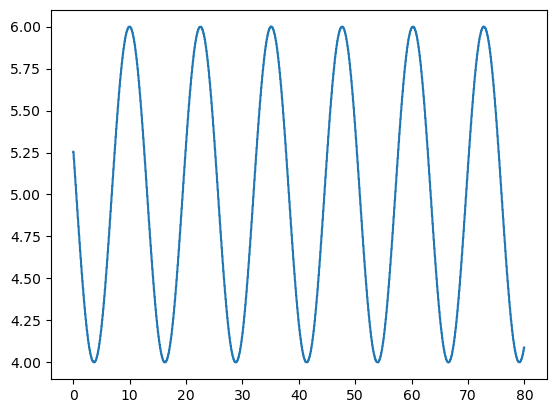

In [48]:
from utils import random_augmentation
import matplotlib.pyplot as plt
x = (torch.arange(1600)/20).unsqueeze(0)
x = torch.cat([x,x], dim = 0)
test = torch.sin(x) + 5
test_aug = random_augmentation(test[0])
plt.plot(x[0], test_aug)  

In [49]:
x.shape

torch.Size([2, 1600])

In [33]:
def standardize(x):
    means = x.mean(dim=1, keepdim=True)
    stds = x.std(dim=1, keepdim=True)
    normalized_data = (x - means) / stds
    return normalized_data                # Tokenize data to shape (batch_size, num_tokens, d_in)
                tokens = tokenizer.forward(x).to(device)

                # Forward pass
                pred = model(tokens)
                loss = criterion(pred, y.to(device))

                losses.append(loss.detach() / batch_size)

                pred_labels = torch.argmax(pred, dim=1)
                num_correct = (pred_labels == y.to(device)).sum()
                accs.append(num_correct.detach() / batch_size)

In [50]:
test = torch.sin(x)+5

In [51]:
test.shape

torch.Size([2, 1600])

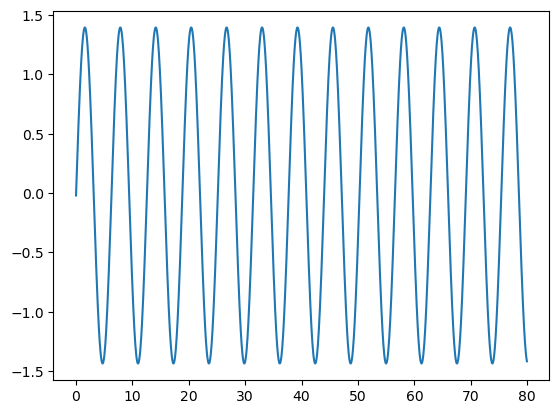

In [54]:
test_std = standardize(test)

plt.plot(x[0], test_std[0])

In [5]:
import torch
from utils import get_fourier_features, get_single_fourier_features

test_input = torch.randn(16, 1600)
test_tokens = get_fourier_features(test_input, 40)

In [6]:
res = torch.Tensor()

for i in range(16):
    res = get_single_fourier_features(test_input[i], 40)
    print(torch.allclose(res, test_tokens[i]))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [7]:
test_tokens

tensor([[[-9.9430e+01, -1.0894e+01,  2.6625e-01],
         [-8.0309e+01,  5.3824e+01,  2.4375e-01],
         [-7.8904e+01, -4.0135e+01,  1.3000e-01],
         ...,
         [-6.7604e+01, -1.4820e+01,  3.5625e-02],
         [ 5.2677e+01,  4.4874e+01,  3.8375e-01],
         [-3.0228e+01,  6.2040e+01,  3.7750e-01]],

        [[ 5.2709e+01, -9.6383e+01,  4.0750e-01],
         [ 4.1914e+01, -9.3809e+01,  1.5313e-01],
         [-7.1052e+01,  6.3507e+01,  1.2062e-01],
         ...,
         [-5.4519e+01, -4.4944e+01,  4.9500e-01],
         [ 6.9141e+01, -1.2210e+01,  2.4750e-01],
         [-4.7837e+01, -5.1075e+01,  4.8125e-02]],

        [[ 5.6345e+01,  9.0184e+01,  1.5125e-01],
         [ 6.8169e+01, -8.0446e+01,  3.5500e-01],
         [ 8.5346e+01, -5.2977e+01,  6.8125e-02],
         ...,
         [ 4.9575e+00,  7.0074e+01,  4.7562e-01],
         [-8.4046e+00,  6.9676e+01,  2.6188e-01],
         [ 6.6930e+01, -2.0362e+01,  3.7875e-01]],

        ...,

        [[ 1.0472e+02,  2.3348e+01,  3

In [10]:
from utils import random_augmentation
from random import random

x = torch.ones(16, 1600)
def augment(x):
    '''
    Augments input sequence
    '''
    for i in range(x.shape[0]):
        # Augment with probability p_aug
        if random() < 0.5:
            x[i] = random_augmentation(x[i])
    return x

x = augment(x)

In [11]:
x.shape

torch.Size([16, 1600])

In [34]:
criterion = torch.nn.CrossEntropyLoss()

test_labels = torch.ones(16).type(torch.LongTensor)
test_pred = torch.zeros(16, 10)
test_pred[:, 1] = 1

In [35]:
criterion(test_pred, test_labels)

tensor(1.4612)

In [21]:
test_pred

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [22]:
test_labels

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [23]:
s = torch.nn.Softmax()

In [33]:
import numpy as np
np.log(.232)

-1.4610179073158271

In [24]:
s(test_pred)

/home/cmu/anaconda3/envs/torch2/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[0.0853, 0.2320, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853,
         0.0853],
        [0.0853, 0.2320, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853,
         0.0853],
        [0.0853, 0.2320, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853,
         0.0853],
        [0.0853, 0.2320, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853,
         0.0853],
        [0.0853, 0.2320, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853,
         0.0853],
        [0.0853, 0.2320, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853,
         0.0853],
        [0.0853, 0.2320, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853,
         0.0853],
        [0.0853, 0.2320, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853,
         0.0853],
        [0.0853, 0.2320, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853,
         0.0853],
        [0.0853, 0.2320, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853,
         0.0853],
        [0

## Pretraining

In [9]:
from torch.utils.data import DataLoader
import random
import wandb
from datetime import datetime
import argparse
import torch
import torch.nn as nn
import numpy as np

from Tokenizer import SignalTokenizer
from wrappers import MaskedWrapper, FinetuneWrapper
from models import BERT, MLP, CNN
from utils import SignalDataset, process_dict

parser = argparse.ArgumentParser(description='FaultFormer')
parser.add_argument('--experiment', type=str, default='Train_End2End_CWRU',
        help='Experiment name')
parser.add_argument('--save_interval', type=int, default=50,
        help='Number of epochs between saving models')
parser.add_argument("--load_bert", type=eval, default=True,
                help='Whether to load bert')
parser.add_argument("--model", type=str, default="BERT",
                help='Model type')

# BERT parameters
parser.add_argument('--batch_size', type=int, default=8,
        help='Number of samples in each minibatch')
parser.add_argument('--num_epochs', type=int, default=1000,
        help='Number of training epochs')
parser.add_argument('--d_in', type=int, default=10,
        help='Input dimension of BERT')
parser.add_argument('--d_out', type=int, default=10,
                help='Output dimension of BERT')
parser.add_argument('--d_model', type=int, default=256,
        help='Model dimension of BERT')
parser.add_argument('--nhead', type=int, default=32,
        help='Number of heads in BERT')
parser.add_argument('--num_layers', type=int, default=4,
        help='Number of layers in BERT')
parser.add_argument('--dropout', type=float, default=0.3,
        help='Dropout probability in BERT')

# Reconstruction parameters
parser.add_argument('--mask_prob', type=float, default=0.5,
        help='Probability to mask out a token')
parser.add_argument('--replace_prob', type=float, default=0.9,
        help='Probability to replace a masked token with 0')
parser.add_argument('--random_token_prob', type=float, default=0.2,
        help='Probability to replace a masked token with a random token')

# Optimizer parameters
parser.add_argument('--min_lr', type=float, default=1e-4,
        help='Minimum learning rate')
parser.add_argument('--max_lr', type=float, default=1e-3,
        help='Maximum learning rate')
parser.add_argument('--beta1', type=float, default=0.9,
        help='Adam beta1')
parser.add_argument('--beta2', type=float, default=0.98,
        help='Adam beta2')

# Scheduler parameters
parser.add_argument('--pct_start', type=float, default=0.1,
        help='Percentage of training to increase learning rate')

# Tokenizer parameters
parser.add_argument('--num_tokens', type=int, default=160,
        help='Number of tokens to generate from a PDE time/spatial sequence')
parser.add_argument('--mode', type=str, default='constant',
        help='Mode for tokenization: [constant, CNN, fourier]')
parser.add_argument('--d_cnn', type=int, default=4,
        help='Number of channels in CNN')
parser.add_argument('--kernel_size', type=int, default=4,
        help='Kernel size in CNN')
parser.add_argument('--stride', type=int, default=2,
        help='Stride in CNN')
parser.add_argument('--fourier_k', type=int, default=40,
        help='Number of fourier modes to keep')
parser.add_argument('--p_aug', type=float, default=0,
                help='Probability of augmentation')

args = parser.parse_args("")

/home/cmu/anaconda3/envs/torch2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
rank = 'cuda'
train_data_path = "/home/cmu/anthony/FaultFormer/FaultFormer/NewAndImprovedISwearItWorks/data_uwu/pretraining_data_full.pt"
train_labels_path = "/home/cmu/anthony/FaultFormer/FaultFormer/NewAndImprovedISwearItWorks/data_uwu/pretraining_labels_full.pt"

#valid_data_path = "/home/ayz2/FaultFormer/NewAndImprovedISwearItWorks/data_uwu/CWRU/Finetuning/test_data_1"
#valid_labels_path = "/home/ayz2/FaultFormer/NewAndImprovedISwearItWorks/data_uwu/CWRU/Finetuning/test_labels_1"

#dataset = SignalDataset(train_data_path, train_labels_path)
#train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2], generator=generator)

train_dataset = SignalDataset(train_data_path, train_labels_path)
#valid_dataset = SignalDataset(valid_data_path, valid_labels_path)
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
#valid_loader = DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=False)

embedding_net = None
if args.model == "BERT":
    model_inner = BERT(d_in=args.d_in,
            d_model = args.d_model,
            nhead = args.nhead,
            num_layers= args.num_layers,
            dropout = args.dropout,
            )

    if args.load_bert:
            bert_path = "/home/ayz2/FaultFormer/NewAndImprovedISwearItWorks/models/BERT_pretrain_CWRU_full_time122176.pt"
            checkpoint = process_dict(torch.load(bert_path, map_location=torch.device('cpu')))
            
            reconstruction_net = nn.Linear(in_features=args.d_model, out_features=args.d_in)
    
            model_checkpoint = MaskedWrapper(net=model_inner,
                            reconstruction_net=reconstruction_net,
                            mask_prob = args.mask_prob,
                            replace_prob = args.replace_prob,
                            random_token_prob = args.random_token_prob)
            model_checkpoint.load_state_dict(checkpoint)
            model_inner = model_checkpoint.net

    embedding_net = nn.Linear(in_features=args.d_model, out_features=args.d_out)

elif args.model == "MLP":
        model_inner = MLP(d_in=args.d_in,
                        d_model = args.d_model,
                        d_out = args.d_out,)
elif args.model == "CNN":
        model_inner = CNN(d_in=args.d_in,
                        d_model = args.d_model,
                        d_out = args.d_out,
                        dropout = args.dropout,)
else: 
    raise Exception("Model not supported")

tokenizer_model = None
if args.mode == "CNN":
    tokenizer_model = nn.Sequential(
    nn.Conv1d(in_channels=1, out_channels=args.d_cnn, kernel_size=args.kernel_size, stride=args.stride, padding="valid"),
    nn.Conv1d(in_channels=args.d_cnn, out_channels=args.d_in, kernel_size=args.kernel_size, stride=args.stride, padding="valid"),
    )

tokenizer = SignalTokenizer(num_tokens=args.num_tokens, mode=args.mode, tokenizer_model=tokenizer_model, fourier_k=args.fourier_k)

model = FinetuneWrapper(net = model_inner,
                            embedding_net=embedding_net,
                            tokenizer=tokenizer,
                            p_aug = args.p_aug,
                            model = args.model).to(rank)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Number of model parameters: {params}')

FileNotFoundError: [Errno 2] No such file or directory: '/home/ayz2/FaultFormer/NewAndImprovedISwearItWorks/models/BERT_pretrain_CWRU_full_time122176.pt'

In [11]:
rank = 'cuda'
train_data_path = "/home/cmu/anthony/FaultFormer/FaultFormer/NewAndImprovedISwearItWorks/data_uwu/pretraining_data_full.pt"
train_labels_path = "/home/cmu/anthony/FaultFormer/FaultFormer/NewAndImprovedISwearItWorks/data_uwu/pretraining_labels_full.pt"

train_dataset = SignalDataset(train_data_path, train_labels_path)
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)

bert_path = "/home/cmu/anthony/FaultFormer/FaultFormer/NewAndImprovedISwearItWorks/models/BERT_Pretrain_full_time128189.pt"
checkpoint = process_dict(torch.load(bert_path, map_location=torch.device('cpu')))

reconstruction_net = nn.Linear(in_features=args.d_model, out_features=args.d_in)
tokenizer = SignalTokenizer(num_tokens=args.num_tokens, mode=args.mode, tokenizer_model=None, fourier_k=args.fourier_k)
model_inner = BERT(d_in=args.d_in,
        d_model = args.d_model,
        nhead = args.nhead,
        num_layers= args.num_layers,
        dropout = args.dropout,
        )
model = MaskedWrapper(net=model_inner,
                reconstruction_net=reconstruction_net,
                tokenizer=tokenizer,
                mask_prob = args.mask_prob,
                replace_prob = args.replace_prob,
                random_token_prob = args.random_token_prob).to(rank)
model.load_state_dict(checkpoint)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Number of model parameters: {params}')

Number of model parameters: 11553802


In [27]:
from utils import process_dict

checkpoint = torch.load("/home/cmu/anthony/FaultFormer/FaultFormer/NewAndImprovedISwearItWorks/models/BERT_pretrain_CWRU_full_time122176.pt")
model.load_state_dict(process_dict(checkpoint))

RuntimeError: Error(s) in loading state_dict for FinetuneWrapper:
	Missing key(s) in state_dict: "net.model.0.weight", "net.model.0.bias", "net.model.2.weight", "net.model.2.bias", "net.model.4.weight", "net.model.4.bias", "net.model.6.weight", "net.model.6.bias", "net.model.8.weight", "net.model.8.bias", "tokenizer.CNN.0.weight", "tokenizer.CNN.0.bias", "tokenizer.CNN.1.weight", "tokenizer.CNN.1.bias". 
	Unexpected key(s) in state_dict: "reconstruction_net.weight", "reconstruction_net.bias", "net.cls_token", "net.encoder.attn_layers.layers.0.0.0.weight", "net.encoder.attn_layers.layers.0.0.0.bias", "net.encoder.attn_layers.layers.0.1.to_q.weight", "net.encoder.attn_layers.layers.0.1.to_k.weight", "net.encoder.attn_layers.layers.0.1.to_v.weight", "net.encoder.attn_layers.layers.0.1.to_out.weight", "net.encoder.attn_layers.layers.1.0.0.weight", "net.encoder.attn_layers.layers.1.0.0.bias", "net.encoder.attn_layers.layers.1.1.ff.0.0.weight", "net.encoder.attn_layers.layers.1.1.ff.0.0.bias", "net.encoder.attn_layers.layers.1.1.ff.2.weight", "net.encoder.attn_layers.layers.1.1.ff.2.bias", "net.encoder.attn_layers.layers.2.0.0.weight", "net.encoder.attn_layers.layers.2.0.0.bias", "net.encoder.attn_layers.layers.2.1.to_q.weight", "net.encoder.attn_layers.layers.2.1.to_k.weight", "net.encoder.attn_layers.layers.2.1.to_v.weight", "net.encoder.attn_layers.layers.2.1.to_out.weight", "net.encoder.attn_layers.layers.3.0.0.weight", "net.encoder.attn_layers.layers.3.0.0.bias", "net.encoder.attn_layers.layers.3.1.ff.0.0.weight", "net.encoder.attn_layers.layers.3.1.ff.0.0.bias", "net.encoder.attn_layers.layers.3.1.ff.2.weight", "net.encoder.attn_layers.layers.3.1.ff.2.bias", "net.encoder.attn_layers.layers.4.0.0.weight", "net.encoder.attn_layers.layers.4.0.0.bias", "net.encoder.attn_layers.layers.4.1.to_q.weight", "net.encoder.attn_layers.layers.4.1.to_k.weight", "net.encoder.attn_layers.layers.4.1.to_v.weight", "net.encoder.attn_layers.layers.4.1.to_out.weight", "net.encoder.attn_layers.layers.5.0.0.weight", "net.encoder.attn_layers.layers.5.0.0.bias", "net.encoder.attn_layers.layers.5.1.ff.0.0.weight", "net.encoder.attn_layers.layers.5.1.ff.0.0.bias", "net.encoder.attn_layers.layers.5.1.ff.2.weight", "net.encoder.attn_layers.layers.5.1.ff.2.bias", "net.encoder.attn_layers.layers.6.0.0.weight", "net.encoder.attn_layers.layers.6.0.0.bias", "net.encoder.attn_layers.layers.6.1.to_q.weight", "net.encoder.attn_layers.layers.6.1.to_k.weight", "net.encoder.attn_layers.layers.6.1.to_v.weight", "net.encoder.attn_layers.layers.6.1.to_out.weight", "net.encoder.attn_layers.layers.7.0.0.weight", "net.encoder.attn_layers.layers.7.0.0.bias", "net.encoder.attn_layers.layers.7.1.ff.0.0.weight", "net.encoder.attn_layers.layers.7.1.ff.0.0.bias", "net.encoder.attn_layers.layers.7.1.ff.2.weight", "net.encoder.attn_layers.layers.7.1.ff.2.bias", "net.encoder.attn_layers.rotary_pos_emb.inv_freq", "net.encoder.attn_layers.final_norm.weight", "net.encoder.attn_layers.final_norm.bias", "net.embedding.weight", "net.embedding.bias". 

In [12]:
x, y = next(iter(train_loader))

In [13]:
y = model(x.to(rank))

KeyboardInterrupt: 

In [5]:
y.shape

torch.Size([8, 10])

In [14]:
x_pred, orig_seq, x_masked = model(x.to(rank), mode = "test")

In [15]:
x_pred.shape

torch.Size([8, 160, 10])

In [16]:
x_masked.shape

torch.Size([8, 160, 10])

Text(0.5, 1.0, 'Original Sequence')

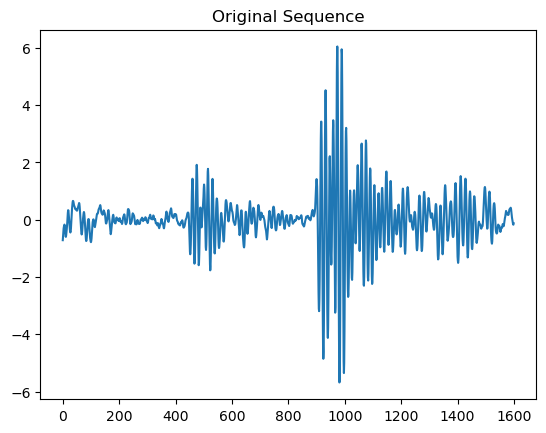

In [21]:
import matplotlib.pyplot as plt
time = torch.arange(1600)
plt.plot(time, torch.flatten(orig_seq[0], 0, 1).detach().cpu().numpy())
plt.title("Original Sequence")

Text(0.5, 1.0, 'Masked Sequence')

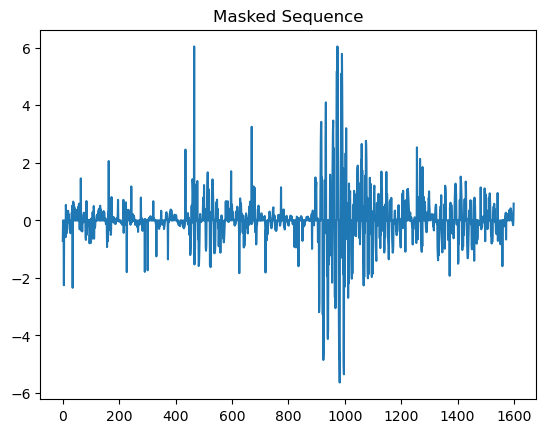

In [23]:
import matplotlib.pyplot as plt
time = torch.arange(1600)
plt.plot(time, torch.flatten(x_masked[0], 0, 1).detach().cpu().numpy())
plt.title("Masked Sequence")

Text(0.5, 1.0, 'Reconstructed Sequence')

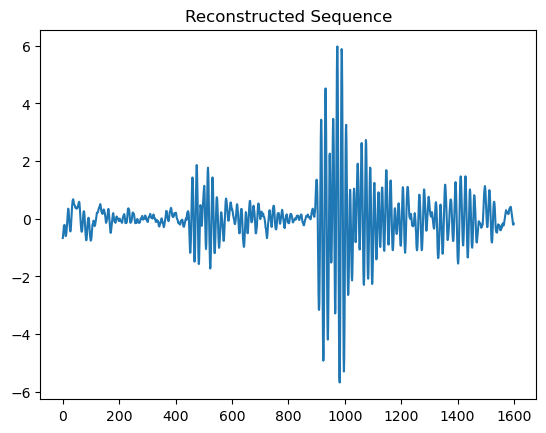

In [24]:
import matplotlib.pyplot as plt
time = torch.arange(1600)
plt.plot(time, torch.flatten(x_pred[0], 0, 1).detach().cpu().numpy())
plt.title("Reconstructed Sequence")

In [25]:
torch.allclose(x_pred[4], orig_seq[4])

False

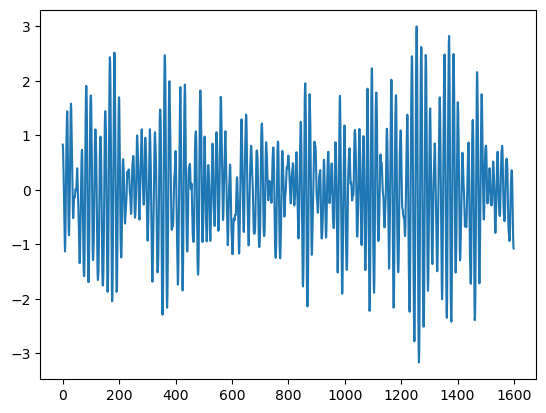

In [7]:
import matplotlib.pyplot as plt
time = torch.arange(1600)

plt.plot(time, x[1])

In [8]:
from utils import get_fourier_features

xfft = get_fourier_features(x)

In [9]:
xfft.shape

torch.Size([8, 40, 3])

In [19]:
x_complex = torch.complex(xfft[:, :, 0], xfft[:, :, 1])

In [23]:
xfft[0]

tensor([[ 3.9809e+02,  9.3157e+01,  5.3125e-02],
        [ 2.5699e+02, -2.0717e+02,  5.2500e-02],
        [ 6.5856e+01, -3.1683e+02,  5.5000e-02],
        [-1.7734e+02, -2.3080e+02,  6.0000e-02],
        [-2.8619e+02, -4.9775e+01,  5.4375e-02],
        [-2.0772e+02, -1.6950e+02,  5.1875e-02],
        [-2.5237e+02, -5.4041e+01,  5.6875e-02],
        [-2.3860e+02,  9.6046e+01,  5.9375e-02],
        [ 2.2858e+02, -1.0219e+02,  5.8125e-02],
        [ 2.2558e+01,  2.3698e+02,  5.8750e-02],
        [-5.1507e+01, -2.2263e+02,  5.7500e-02],
        [ 2.1015e+02,  6.8859e+00,  5.5625e-02],
        [-1.2147e+02,  1.1062e+02,  5.1250e-02],
        [ 3.9520e+01,  1.5205e+02,  5.0625e-02],
        [ 1.4995e+02,  3.5310e+01,  5.0000e-02],
        [-8.6351e+01, -1.1365e+02,  6.9375e-02],
        [-1.9633e+01,  1.1892e+02,  5.6250e-02],
        [-8.8616e+01,  6.4872e+01,  5.3750e-02],
        [-8.5700e+01,  5.7672e+01,  6.6250e-02],
        [-7.2937e+01, -7.1421e+01,  6.2500e-02],
        [-4.1529e+01

In [22]:
x_complex[0]

tensor([ 398.0899+93.1566j,  256.9889-207.1717j,   65.8560-316.8319j,
        -177.3370-230.7976j, -286.1879-49.7754j, -207.7211-169.4967j,
        -252.3748-54.0407j, -238.5986+96.0455j,  228.5821-102.1906j,
          22.5585+236.9848j,  -51.5074-222.6251j,  210.1507+6.8859j,
        -121.4702+110.6158j,   39.5205+152.0472j,  149.9509+35.3102j,
         -86.3508-113.6525j,  -19.6334+118.9192j,  -88.6162+64.8718j,
         -85.7005+57.6721j,  -72.9374-71.4214j,  -41.5293+89.6899j,
         -87.1122+44.6903j,    7.1462-96.8772j,  -70.9047+59.2061j,
          30.0792+83.4875j,   26.6784+74.3628j,  -71.0023+27.6450j,
          14.5745+69.4861j,   42.6824+52.2537j,   38.3640-49.2326j,
          20.7230+57.5984j,  -55.3274+25.5273j,  -47.8254-34.8998j,
         -24.6914+50.7871j,   35.6819-40.5737j,  -14.9652-51.7872j,
          -8.4159+51.1946j,  -30.4895+40.6077j,   50.2628+2.9737j,
          20.8018+43.0484j])

In [26]:
data_reconstructed = torch.fft.irfft(x_complex, 800)

In [16]:
xfft[0, :, :2].shape

torch.Size([40, 2])

In [27]:
data_reconstructed.shape

torch.Size([8, 800])

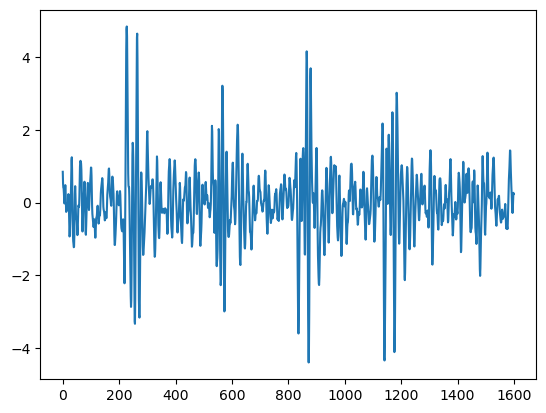

In [28]:
import matplotlib.pyplot as plt
time = torch.arange(1600)

plt.plot(time, x[1])

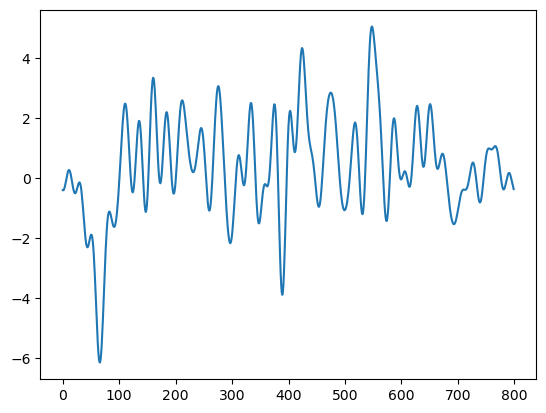

In [29]:
import matplotlib.pyplot as plt
time = torch.arange(800)

plt.plot(time, data_reconstructed[1])

In [36]:
spectral_reconstruction

tensor([   0.0000+0.0000j,    0.0000+0.0000j,    0.0000+0.0000j,
           0.0000+0.0000j,    0.0000+0.0000j,    0.0000+0.0000j,
           0.0000+0.0000j,    0.0000+0.0000j,    0.0000+0.0000j,
           0.0000+0.0000j,    0.0000+0.0000j,    0.0000+0.0000j,
          14.5745+69.4861j,    0.0000+0.0000j,    0.0000+0.0000j,
           0.0000+0.0000j,  -30.4895+40.6077j,    0.0000+0.0000j,
           0.0000+0.0000j,    0.0000+0.0000j,    0.0000+0.0000j,
           0.0000+0.0000j,    0.0000+0.0000j,    0.0000+0.0000j,
           0.0000+0.0000j,    0.0000+0.0000j,    0.0000+0.0000j,
           0.0000+0.0000j,    0.0000+0.0000j,    0.0000+0.0000j,
           0.0000+0.0000j,    0.0000+0.0000j,  -71.0023+27.6450j,
           0.0000+0.0000j,    0.0000+0.0000j,    0.0000+0.0000j,
          20.7230+57.5984j,    0.0000+0.0000j,  -55.3274+25.5273j,
           0.0000+0.0000j,    0.0000+0.0000j,    0.0000+0.0000j,
           0.0000+0.0000j,    0.0000+0.0000j,    0.0000+0.0000j,
           0.0000+0.

In [10]:
import matplotlib.pyplot as plt

k = 40
data = x

batch_size, seq_len = data.shape

time = torch.arange(seq_len)

x_fft = get_fourier_features(data, k)
data_spectral = torch.complex(x_fft[:, :, 0], x_fft[:, :, 1])
max_idx = x_fft[:, :, 2]

spectral_reconstruction = torch.zeros()

for i in range(k):
    idx = max_idx[i]
    spectral_reconstruction[idx] = data_spectral[idx]

print(spectral_reconstruction.shape)

data_reconstructed = torch.fft.irfft(spectral_reconstruction)

print(data_reconstructed.shape)

plt.figure(0)
plt.plot(time, data)

plt.figure(1)
plt.plot(time, data_reconstructed)

TypeError: zeros() received an invalid combination of arguments - got (), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [18]:
import numpy as np
data = np.load("/home/cmu/anthony/FaultFormer/FaultFormer/data/Paderborn/raw_signal_labels.npy")

In [19]:
data.shape

(58000,)

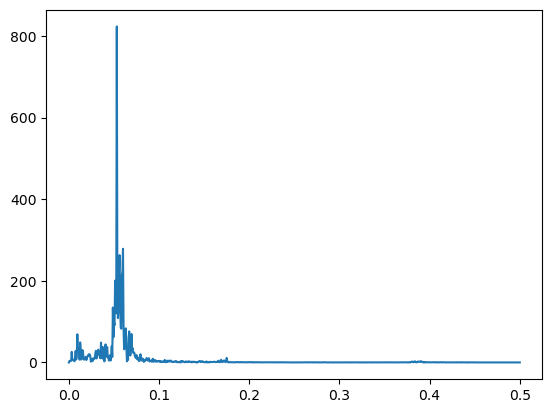

In [17]:
plt.plot(freqs, mag)   

torch.Size([801])
torch.Size([1600])


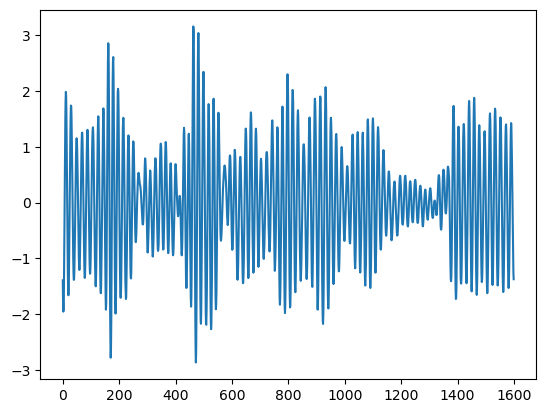

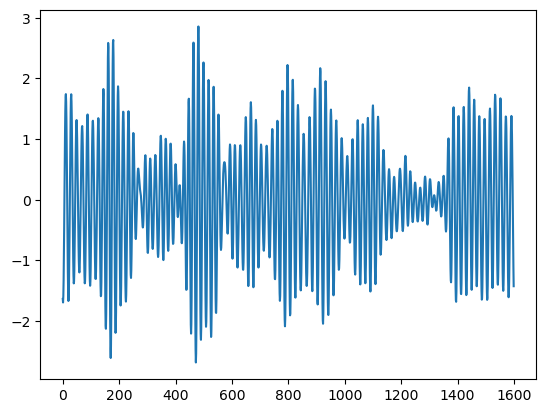

In [16]:
import matplotlib.pyplot as plt

k = 40
data = x[0]

time = torch.arange(len(data))

data_spectral = torch.fft.rfft(data)
freqs = torch.fft.rfftfreq(len(data))
data_r = data_spectral.real
data_i = data_spectral.imag
mag = torch.sqrt(data_r*data_r + data_i*data_i)

max_amp, max_idx = torch.topk(mag, k)
spectral_reconstruction = torch.zeros_like(data_spectral)

for i in range(k):
    idx = max_idx[i]
    spectral_reconstruction[idx] = data_spectral[idx]

print(spectral_reconstruction.shape)

data_reconstructed = torch.fft.irfft(spectral_reconstruction)

print(data_reconstructed.shape)

plt.figure(0)
plt.plot(time, data)

plt.figure(1)
plt.plot(time, data_reconstructed)

torch.Size([801])
torch.Size([1600])


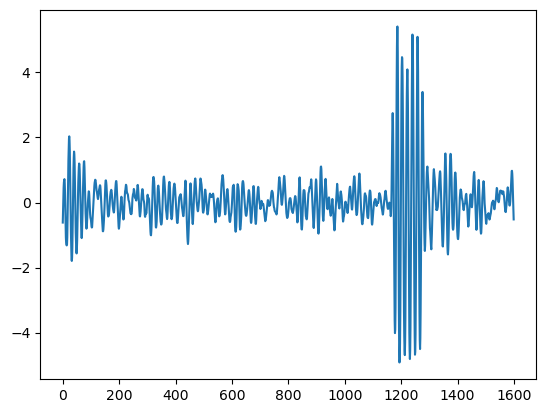

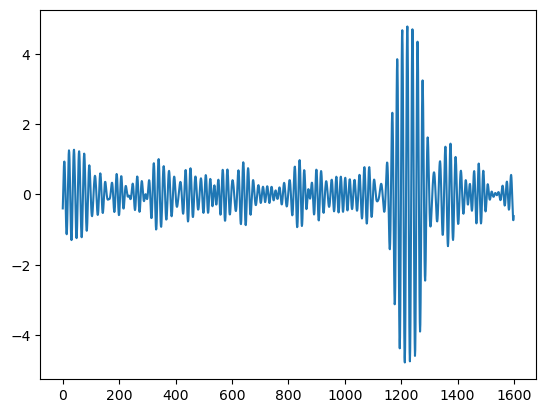

In [34]:
test_fourier_features(x[0])

In [9]:
import matplotlib.pyplot as plt
from utils import get_fourier_features

def test_fourier_features(data):
    '''
    data: Tensor of shape [seq_len]
    '''
    signal_len = len(data)
    
    data_fft = get_fourier_features(data)
    
    data_reconstructed = torch.fft.irfft(data_fft[], n = )

    plt.figure(0)
    plt.plot(time, data)

    plt.figure(1)
    plt.plot(time, data_reconstructed)

torch.Size([8, 40, 3])

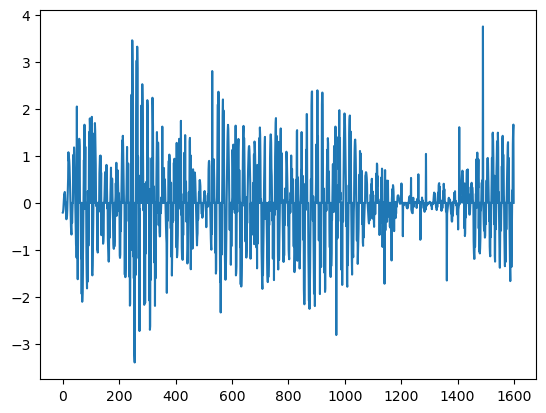

In [32]:
plt.plot(x, torch.flatten(x_masked[8], 0, 1).detach().cpu())

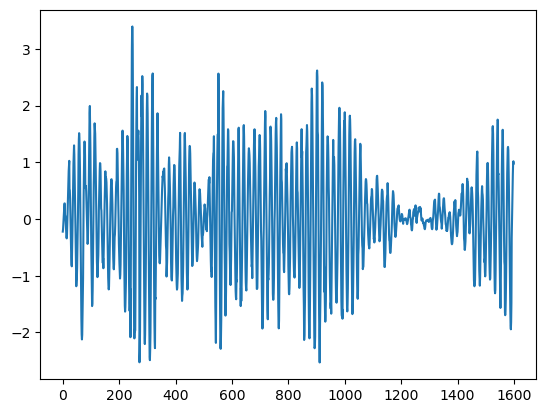

In [33]:
plt.plot(x, torch.flatten(x_pred[8], 0, 1).detach().cpu())

## Reduced Dataset

In [7]:
train_data = torch.load("/home/cmu/anthony/FaultFormer/FaultFormer/data/CWRU/kfold/test_data_1")
train_labels = torch.load("/home/cmu/anthony/FaultFormer/FaultFormer/data/CWRU/kfold/test_labels_1")

In [8]:
train_data.shape

torch.Size([560, 1600])

In [13]:
def count_classes(labels):
    counts = torch.zeros(10)
    for l in labels:
        counts[int(l.item())] += 1
    return counts

In [14]:
count_classes(train_labels)

tensor([55., 57., 57., 59., 47., 61., 61., 56., 52., 55.])

In [91]:
from sklearn.model_selection import train_test_split
test_data_400, test_data_100, test_labels_400, test_labels_100 = train_test_split(train_data, train_labels, test_size=100, random_state=1)

In [95]:
_, test_data_100_new, _, test_labels_100_new= train_test_split(test_data_400, test_labels_400, test_size=100, random_state=12)

In [96]:
count_classes(test_labels_100_new)

tensor([ 9.,  7.,  8., 10., 12., 14.,  8.,  9., 10., 13.])

In [85]:
test_data_100.shape

torch.Size([100, 1600])

In [97]:
torch.save(test_data_100_new, "data_uwu/test_data_100_new.pt")

In [98]:
torch.save(test_labels_100_new, "data_uwu/test_labels_100_new.pt")

## Visualizations

In [5]:
epochs = [1, 2, 5, 20, 40]
bert_pt = [0.4688, 0.5625, 0.5833, 0.8594, 0.875]
bert = [0.4948, 0.5573, 0.6042, 0.8177, 0.8125]
cnn = [0.3177, 0.3177, 0.3333, 0.6354, 0.8073]
mlp = [0.3177, 0.3177, 0.3299, 0.7656, 0.776]

[]

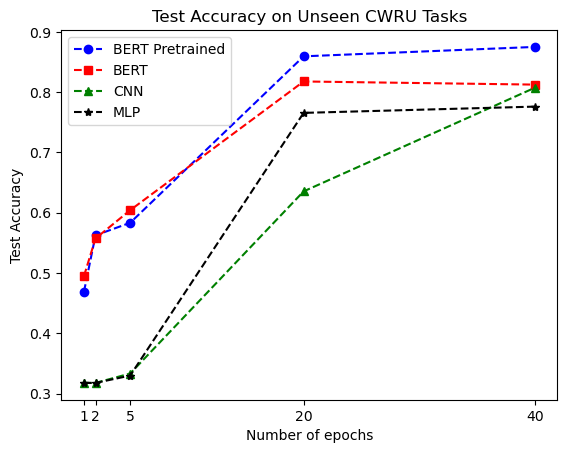

In [7]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(epochs, bert_pt, '--bo', label = "BERT Pretrained")
plt.plot(epochs, bert, '--rs', label = "BERT")
plt.plot(epochs, cnn, '--g^', label = "CNN")
plt.plot(epochs, mlp, '--k*', label = "MLP")
plt.xlabel("Number of epochs")
plt.ylabel("Test Accuracy")
plt.legend()

plt.xticks(epochs)
plt.title("Test Accuracy on Unseen CWRU Tasks")

plt.plot()

In [1]:
epochs = [1, 2, 5, 10, 20]
bert_pt = [0.8010, 0.9021, 0.9691, 0.9909, 0.9946]
bert = [0.6509, 0.7922, 0.9257, 0.9599, 0.9700]
cnn = [0.5509, 0.7088, 0.8141, 0.9111, 0.9667]
mlp = [0.4293, 0.5323, 0.6566, 0.7032, 0.7964]

[]

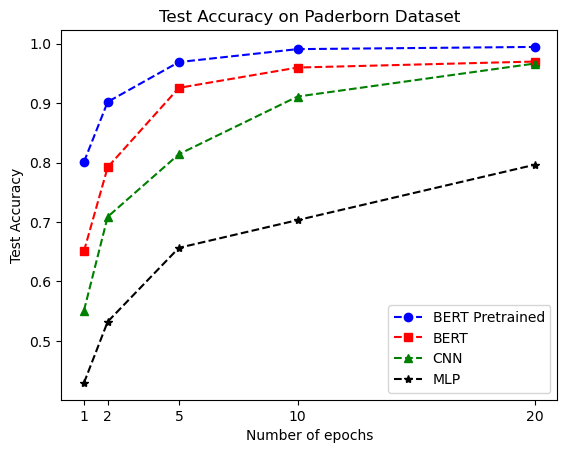

In [2]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(epochs, bert_pt, '--bo', label = "BERT Pretrained")
plt.plot(epochs, bert, '--rs', label = "BERT")
plt.plot(epochs, cnn, '--g^', label = "CNN")
plt.plot(epochs, mlp, '--k*', label = "MLP")
plt.xlabel("Number of epochs")
plt.ylabel("Test Accuracy")
plt.legend()

plt.xticks(epochs)
plt.title("Test Accuracy on Paderborn Dataset")

plt.plot()

In [49]:
num_samples = [100, 200, 400]
bert_pt = [0.8125, 0.8047, 0.8125]
bert = [0.7813, 0.7578, 0.7734]
cnn = [0.7422, 0.7656, 0.8047]
mlp = [0.7578, 0.7734, 0.8047]

[]

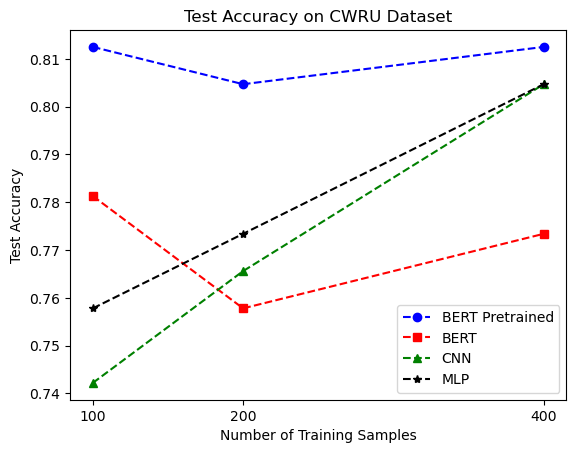

In [52]:

plt.figure()
plt.plot(num_samples, bert_pt, '--bo', label = "BERT Pretrained")
plt.plot(num_samples, bert, '--rs', label = "BERT")
plt.plot(num_samples, cnn, '--g^', label = "CNN")
plt.plot(num_samples, mlp, '--k*', label = "MLP")
plt.xlabel("Number of Training Samples")
plt.ylabel("Test Accuracy")
plt.legend()

plt.xticks(num_samples)
plt.title("Test Accuracy on CWRU Dataset")

plt.plot()